# Unsupervised Learning - Emotion Detection
Apply clustering and dimension reduction algorithms, and see how they may help the Neural Netowrk learner

## Import packages

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import (
    accuracy_score, mean_squared_error,
    adjusted_rand_score, adjusted_mutual_info_score,
    homogeneity_score, completeness_score, v_measure_score,
)
import time
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, FastICA
import seaborn as sns
from sklearn.mixture import GaussianMixture
from sklearn.random_projection import GaussianRandomProjection
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from keras.models import Sequential
from keras.layers import AveragePooling2D, Conv2D, Dense, Flatten, Reshape
from keras.utils import to_categorical
import random

## Load data

In [2]:
data = pd.read_csv('data/emotion-detection/icml_face_data.csv/icml_face_data.csv')
data = data.rename(columns={' Usage': 'Usage', ' pixels': 'pixels'})  # Somehow column names conatin a leading space

## Set aside a test set

In [3]:
train_set = data[data['Usage']=='Training']
test_set = data[data['Usage']=='PrivateTest']
print(len(train_set), 'train istances +', len(test_set), 'test instances')

28709 train istances + 3589 test instances


## Clean data and normalize features

In [106]:
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_name):
        self.attribute_name = attribute_name
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_name].str.strip('"').str.split(pat=' ', expand=True).values

pipeline = Pipeline([
    ('selector', DataFrameSelector('pixels')),
    ('std_scaler', StandardScaler()),
])

train_X = pipeline.fit_transform(train_set)
train_y = np.array(train_set['emotion'])
test_X = pipeline.transform(test_set)
test_y = np.array(test_set['emotion'])

## Part I: Run clustering algorithms

In [75]:
clustering_algorithm = 'k_means'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 12  # Set to an integer (discovered best n_clusters) or a list of integers (to discover best n_clusters)

In [90]:
def constuct_clustering_model(clustering_algorithm, n_clusters):
    if clustering_algorithm == 'k_means':
        clustering_model = KMeans(random_state=0, n_clusters=n_clusters)
    elif clustering_algorithm == 'em':
        clustering_model = GaussianMixture(random_state=0, n_components=n_clusters)
    return clustering_model

def run_clustering_algorithm(clustering_algorithm, n_clusters, train_X):
    if isinstance(n_clusters, int):
        clustering_model = constuct_clustering_model(clustering_algorithm, n_clusters)
        start_time = time.time()
        clustering_model.fit(train_X)
        end_time = time.time()
        print('-----------------------------------------------------------------------')
        print('Result for n_clusters: {}'.format(n_clusters))
        print('Time elapsed (in seconds): {}'.format(end_time - start_time))
        if clustering_algorithm == 'k_means':
            print('Sum of squared distances of samples to their closest cluster center: {}'
                  .format(clustering_model.inertia_))
        elif clustering_algorithm == 'em':
            print('AIC: {0}, and BIC: {1}'.format(clustering_model.aic(train_X), clustering_model.bic(train_X)))
    elif isinstance(n_clusters, list):
        sses = []
        aics = []
        bics = []
        for n in n_clusters:
            clustering_model = constuct_clustering_model(clustering_algorithm, n)
            start_time = time.time()
            clustering_model.fit(train_X)
            end_time = time.time()
            print('-----------------------------------------------------------------------')
            print('Result for n_clusters: {}'.format(n))
            print('Time elapsed (in seconds): {}'.format(end_time - start_time))
            if clustering_algorithm == 'k_means':
                print('Sum of squared distances of samples to their closest cluster center: {}'
                      .format(clustering_model.inertia_))
                sses.append(clustering_model.inertia_)
            elif clustering_algorithm == 'em':
                aic = clustering_model.aic(train_X)
                bic = clustering_model.bic(train_X)
                print('AIC: {0}, and BIC: {1}'.format(aic, bic))
                aics.append(aic)
                bics.append(bic)
        if clustering_algorithm == 'k_means':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, sses)
            plt.title('Sum of squared distances of samples to their closest cluster center')
            plt.xlabel('k')
            plt.ylabel('Sum Squared Error')
            plt.show()
        elif clustering_algorithm == 'em':
            plt.figure(random.randint(0, 10000))
            plt.plot(n_clusters, aics, label='AIC')
            plt.plot(n_clusters, bics, label='BIC')
            plt.legend(loc='lower right')
            plt.title('AIC or BIC v.s. k')
            plt.xlabel('k')
            plt.ylabel('AIC or BIC')
            plt.show()
    else:
        raise ValueError('Invalid argument n_clusters: {}. Only int or list of int supported!'.format(n_clusters))
    return clustering_model

In [77]:
def eval_clustering_result(train_y, pred_y):
    print('Adjusted rand score: {}'.format(adjusted_rand_score(train_y, pred_y)))
    print('Adjusted mutual information score: {}'.format(adjusted_mutual_info_score(train_y, pred_y)))
    print('Homogeneity score: {}'.format(homogeneity_score(train_y, pred_y)))
    print('Completeness score: {}'.format(completeness_score(train_y, pred_y)))
    print('V-measure score: {}'.format(v_measure_score(train_y, pred_y)))

In [78]:
def sample_rows(X, y, num_rows_to_sample):
    num_total_rows = X.shape[0]
    random_indices = np.random.choice(num_total_rows, size=num_rows_to_sample, replace=False)
    return X[random_indices, :], y[random_indices]

-----------------------------------------------------------------------
Result for n_clusters: 7
Time elapsed (in seconds): 26.621976137161255
Sum of squared distances of samples to their closest cluster center: 44042358.10487558
Adjusted rand score: 0.009162175010057613
Adjusted mutual information score: 0.016499200421321497
Homogeneity score: 0.017446654533488277
Completeness score: 0.016251976735859944
V-measure score: 0.016828138883773783


(array([0, 2, 5, ..., 1, 1, 3], dtype=int32),
 KMeans(n_clusters=7, random_state=0))

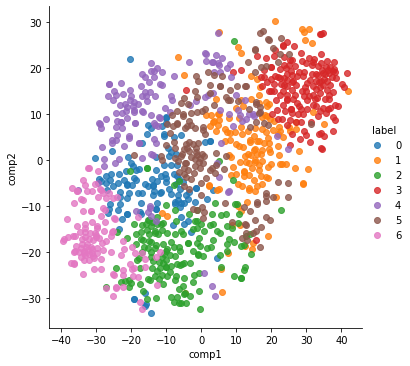

In [139]:
def clustering_all_in_one(clustering_algorithm, n_clusters, train_X):
    # Run clustering algorithm
    clustering_model = run_clustering_algorithm(clustering_algorithm, n_clusters, train_X)
    # Evaluate clustering result against true labels
    pred_y = clustering_model.predict(train_X)
    eval_clustering_result(train_y, pred_y)
    # Visulize clustering result in 2D
    reduced_X = PCA(n_components=50).fit_transform(train_X)
    sampled_X, sampled_y = sample_rows(reduced_X, pred_y, 1000)
    embedded_X = TSNE(n_components=2).fit_transform(sampled_X)
    df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
    df_tsne['label'] = sampled_y
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    return pred_y, clustering_model

clustering_all_in_one(clustering_algorithm, n_clusters, train_X)

## Part II: Apply dimensionality reduction algorithms

In [80]:
dr_algorithm = 'pca'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 50

In [81]:
def construct_dr_model(dr_algorithm, n_components):
    if dr_algorithm == 'pca':
        dr_model = PCA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'ica':
        dr_model = FastICA(random_state=0, n_components=n_components)
    elif dr_algorithm == 'random_projection':
        dr_model = GaussianRandomProjection(random_state=0, n_components=n_components)
    elif dr_algorithm == 'lda':
        dr_model = LinearDiscriminantAnalysis(n_components=n_components)
    return dr_model

MSE between original data and reconstructed data: 0.1644694590706735


(array([[  6.84361405,  10.88772484,  10.38739265, ...,  -3.28321712,
           0.60957405,  -3.71233853],
        [  4.79122228, -12.2089534 ,  -5.38805472, ...,   0.15288243,
           2.7504367 ,  -1.13644145],
        [-27.43320451,  14.25941102,  21.76340711, ...,   2.33951792,
           1.32646981,  -5.81012984],
        ...,
        [ -8.32252759, -12.97309205, -15.15138387, ...,   1.30400196,
           0.28049432,  -0.28517237],
        [ -4.57263364,  -7.10299952,  -4.62380336, ...,   2.83070595,
          -0.40981206,  -3.7290462 ],
        [-35.08213614,  -0.78634486,   9.62335946, ...,  -0.71464344,
          -3.69655944,  -2.80988344]]),
 PCA(n_components=50, random_state=0))

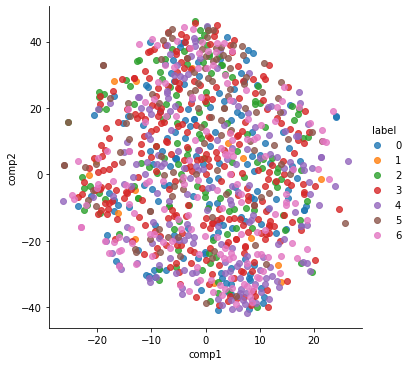

In [115]:
def dr_all_in_one(dr_algorithm, n_components, train_X, train_y):
    # Apply dimensionality reduction algorithm
    dr_model = construct_dr_model(dr_algorithm, n_components)
    reduced_X = dr_model.fit_transform(train_X, train_y)
    # Evaluate MSE between original data and reconstructed data (if possible)
    if dr_algorithm == 'pca' or dr_algorithm == 'ica':
        reconstructed_X = dr_model.inverse_transform(reduced_X)
        print('MSE between original data and reconstructed data: {}'
              .format(mean_squared_error(train_X, reconstructed_X)))
    # Visulize dimensionality reduction result against true labels in 2D
    sampled_X, sampled_y = sample_rows(reduced_X, train_y, 1000)
    embedded_X = TSNE(n_components=2).fit_transform(sampled_X)
    df_tsne = pd.DataFrame(embedded_X, columns=['comp1', 'comp2'])
    df_tsne['label'] = sampled_y
    sns.lmplot(x='comp1', y='comp2', data=df_tsne, hue='label', fit_reg=False)
    
    return reduced_X, dr_model

dr_all_in_one(dr_algorithm, n_components, train_X, train_y)

## Part III: Run clustering algorithm after dimensionality reduction

In [116]:
# Dimensionality reduction settings
dr_algorithm = 'pca'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 50

# Clustering settings
clustering_algorithm = 'k_means'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 7  # Set to an integer (discovered best n_clusters) or a list (to discover best n_clusters)

MSE between original data and reconstructed data: 0.1644694590706735
-----------------------------------------------------------------------
Result for n_clusters: 7
Time elapsed (in seconds): 0.9670698642730713
Sum of squared distances of samples to their closest cluster center: 33165528.289256133
Adjusted rand score: 0.009194773950806753
Adjusted mutual information score: 0.016558867778002456
Homogeneity score: 0.01750866160573365
Completeness score: 0.01630943069799484
V-measure score: 0.01688778305462683


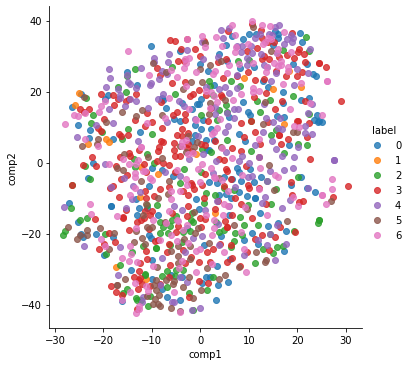

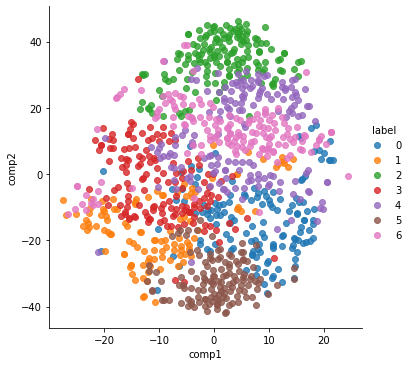

In [117]:
reduced_X, _ = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
clustering_all_in_one(clustering_algorithm, n_clusters, reduced_X)

## Part IV: Apply neural network learner after dimensionality reduction

In [149]:
# Dimensionality reduction settings
dr_algorithm = 'pca'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 100

# Neural netowrk learner settings
neural_netowrk_hyper_parameters = {
    'compiler': {
        'loss': 'categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy'],
    },
    'epochs': 200,
    'batch_size': 1000,
    'verbose': 1,
}

MSE between original data and reconstructed data: 0.10795538669776472
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_12 (Reshape)         (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 8, 8, 6)           60        
_________________________________________________________________
average_pooling2d_23 (Averag (None, 4, 4, 6)           0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 2, 2, 16)          880       
_________________________________________________________________
average_pooling2d_24 (Averag (None, 1, 1, 16)          0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 16)                0         
_________________________________________________

29/29 [==============================] - 0s 7ms/step - loss: 1.6706 - accuracy: 0.3305 - val_loss: 1.6890 - val_accuracy: 0.3174
Epoch 48/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6704 - accuracy: 0.3287 - val_loss: 1.6877 - val_accuracy: 0.3115
Epoch 49/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6677 - accuracy: 0.3297 - val_loss: 1.6911 - val_accuracy: 0.3082
Epoch 50/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6663 - accuracy: 0.3290 - val_loss: 1.6867 - val_accuracy: 0.3112
Epoch 51/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6653 - accuracy: 0.3318 - val_loss: 1.6867 - val_accuracy: 0.3143
Epoch 52/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6653 - accuracy: 0.3319 - val_loss: 1.6898 - val_accuracy: 0.3179
Epoch 53/200
29/29 [==============================] - 0s 8ms/step - loss: 1.6639 - accuracy: 0.3316 - val_loss: 1.6857 - val_accuracy: 0.3143
Epoch 54/200
29/29 

Epoch 105/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6252 - accuracy: 0.3526 - val_loss: 1.6679 - val_accuracy: 0.3316
Epoch 106/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6229 - accuracy: 0.3543 - val_loss: 1.6691 - val_accuracy: 0.3321
Epoch 107/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6214 - accuracy: 0.3546 - val_loss: 1.6672 - val_accuracy: 0.3277
Epoch 108/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6227 - accuracy: 0.3539 - val_loss: 1.6719 - val_accuracy: 0.3282
Epoch 109/200
29/29 [==============================] - 0s 7ms/step - loss: 1.6222 - accuracy: 0.3564 - val_loss: 1.6755 - val_accuracy: 0.3302
Epoch 110/200
29/29 [==============================] - 0s 8ms/step - loss: 1.6222 - accuracy: 0.3535 - val_loss: 1.6671 - val_accuracy: 0.3338
Epoch 111/200
29/29 [==============================] - 0s 8ms/step - loss: 1.6238 - accuracy: 0.3525 - val_loss: 1.6669 - val_accuracy: 0.3335

29/29 [==============================] - 0s 8ms/step - loss: 1.5948 - accuracy: 0.3685 - val_loss: 1.6671 - val_accuracy: 0.3335
Epoch 163/200
29/29 [==============================] - 0s 7ms/step - loss: 1.5944 - accuracy: 0.3719 - val_loss: 1.6604 - val_accuracy: 0.3302
Epoch 164/200
29/29 [==============================] - 0s 9ms/step - loss: 1.5920 - accuracy: 0.3696 - val_loss: 1.6630 - val_accuracy: 0.3293
Epoch 165/200
29/29 [==============================] - 0s 8ms/step - loss: 1.5928 - accuracy: 0.3705 - val_loss: 1.6600 - val_accuracy: 0.3316
Epoch 166/200
29/29 [==============================] - 0s 7ms/step - loss: 1.5935 - accuracy: 0.3710 - val_loss: 1.6668 - val_accuracy: 0.3321
Epoch 167/200
29/29 [==============================] - 0s 7ms/step - loss: 1.5936 - accuracy: 0.3725 - val_loss: 1.6626 - val_accuracy: 0.3310
Epoch 168/200
29/29 [==============================] - 0s 8ms/step - loss: 1.5937 - accuracy: 0.3692 - val_loss: 1.6657 - val_accuracy: 0.3344
Epoch 169/200

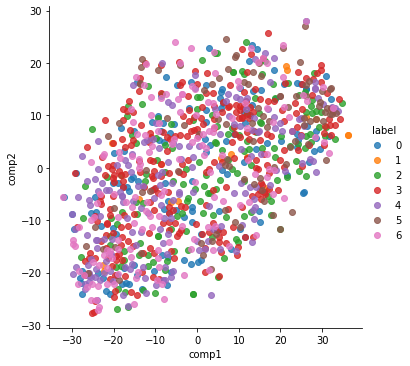

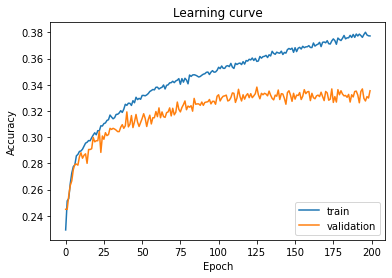

In [150]:
def construct_neural_network_model_1():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Reshape((10, 10, 1), input_shape=(100,)))
    clf.add(Conv2D(filters=6, kernel_size=(3, 3), activation='relu', input_shape=(10, 10, 1)))
    clf.add(AveragePooling2D())
    clf.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu'))
    clf.add(AveragePooling2D())
    clf.add(Flatten())
    clf.add(Dense(units=120, activation='relu'))
    clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**neural_netowrk_hyper_parameters['compiler'])
    clf.summary()
    return clf

def plot_learning_curve(training_history):
    plt.figure(random.randint(0, 10000))
    plt.plot(training_history.history['accuracy'])
    plt.plot(training_history.history['val_accuracy'])
    plt.title('Learning curve')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='lower right')
    plt.show()

def run_neural_netowrk_learner(clf, train_X, train_y, test_X, test_y):
    categorical_train_y = to_categorical(train_y, 7)
    categorical_test_y = to_categorical(test_y, 7)
    training_history = clf.fit(
        train_X, categorical_train_y,
        validation_data=([test_X], [categorical_test_y]),
        epochs=neural_netowrk_hyper_parameters['epochs'],
        batch_size=neural_netowrk_hyper_parameters['batch_size'],
    )
    return training_history
    
reduced_train_X, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
reduced_test_X = dr_model.transform(test_X)
clf = construct_neural_network_model_1()
training_history = run_neural_netowrk_learner(clf, reduced_train_X, train_y, reduced_test_X, test_y)
plot_learning_curve(training_history)

## Part V: Apply neural network learner after dimensionality reduction and clustering

In [151]:
# Dimensionality reduction settings
dr_algorithm = 'pca'
assert dr_algorithm in {'pca', 'ica', 'random_projection', 'lda'}
n_components = 50

# Clustering settings
clustering_algorithm = 'k_means'
assert clustering_algorithm in {'k_means', 'em'}
n_clusters = 7  # Set to an integer (discovered best n_clusters) or a list (to discover best n_clusters)

# Neural netowrk learner settings
neural_netowrk_hyper_parameters = {
    'compiler': {
        'loss': 'categorical_crossentropy',
        'optimizer': 'adam',
        'metrics': ['accuracy'],
    },
    'epochs': 100,
    'batch_size': 1000,
    'verbose': 1,
}

MSE between original data and reconstructed data: 0.1644694590706735
-----------------------------------------------------------------------
Result for n_clusters: 7
Time elapsed (in seconds): 1.0111150741577148
Sum of squared distances of samples to their closest cluster center: 33165528.289256133
Adjusted rand score: 0.009194773950806753
Adjusted mutual information score: 0.016558867778002456
Homogeneity score: 0.01750866160573365
Completeness score: 0.01630943069799484
V-measure score: 0.01688778305462683
Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 64)                512       
_________________________________________________________________
dense_46 (Dense)             (None, 7)                 455       
Total params: 967
Trainable params: 967
Non-trainable params: 0
_________________________________________________________________
Epo

Epoch 51/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7783 - accuracy: 0.2565 - val_loss: 1.7811 - val_accuracy: 0.2469
Epoch 52/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7784 - accuracy: 0.2565 - val_loss: 1.7810 - val_accuracy: 0.2469
Epoch 53/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7782 - accuracy: 0.2565 - val_loss: 1.7811 - val_accuracy: 0.2469
Epoch 54/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7783 - accuracy: 0.2565 - val_loss: 1.7810 - val_accuracy: 0.2469
Epoch 55/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7783 - accuracy: 0.2565 - val_loss: 1.7810 - val_accuracy: 0.2469
Epoch 56/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7784 - accuracy: 0.2565 - val_loss: 1.7812 - val_accuracy: 0.2469
Epoch 57/100
29/29 [==============================] - 0s 1ms/step - loss: 1.7783 - accuracy: 0.2565 - val_loss: 1.7809 - val_accuracy: 0.2469
Epoch 

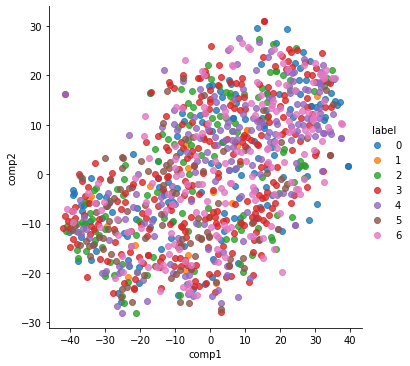

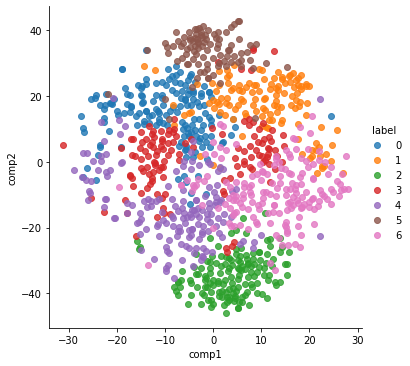

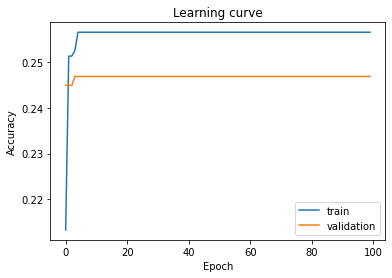

In [152]:
def construct_neural_network_model_2():
    # The famous LeNet-5 neural network with the following adaptation:
    # 1. proper reshaping at the beginning to fit desired input shape
    # 2. last layer of units=7 to fit 7-class classification
    # Codes are adapted from https://medium.com/@mgazar/lenet-5-in-9-lines-of-code-using-keras-ac99294c8086
    clf = Sequential()
    clf.add(Dense(units=64, activation='relu', input_shape=(n_clusters,)))
    # clf.add(Dense(units=120, activation='relu', input_shape=(n_clusters,)))
    # clf.add(Dense(units=84, activation='relu'))
    clf.add(Dense(units=7, activation='softmax'))
    clf.compile(**neural_netowrk_hyper_parameters['compiler'])
    clf.summary()
    return clf

reduced_train_X, dr_model = dr_all_in_one(dr_algorithm, n_components, train_X, train_y)
reduced_test_X = dr_model.transform(test_X)
train_cluster_labels, clustering_model = clustering_all_in_one(clustering_algorithm, n_clusters, reduced_train_X)
test_cluster_labels = clustering_model.predict(reduced_test_X)
one_hot = OneHotEncoder()
one_hot_train_cluster_labels = one_hot.fit_transform(train_cluster_labels.reshape(-1, 1)).todense()
one_hot_test_cluster_labels = one_hot.transform(test_cluster_labels.reshape(-1, 1)).todense()
clf = construct_neural_network_model_2()
training_history = run_neural_netowrk_learner(
    clf, one_hot_train_cluster_labels, train_y, one_hot_test_cluster_labels, test_y)
plot_learning_curve(training_history)

## Find the optimal number of clusters for EM clustering algorithm (AIC v.s. k)

Text(0, 0.5, 'AIC')

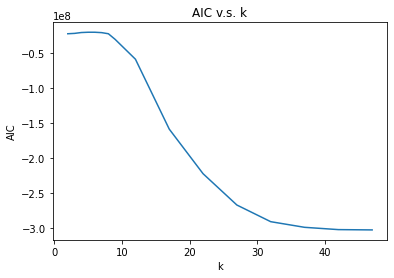

In [31]:
ks = [2, 3, 4, 5, 6, 7, 8, 9, 12, 17, 22, 27, 32, 37, 42, 47]
aics = [
    -22786227, -22268370, -21047018, -20639959, -20645531, -21186225, -22776226, -30798420,
    -59034047, -158605842, -222114231, -266712281, -290427949, -298452091, -301724395, -302160510,
]
plt.plot(ks, aics)
plt.title('AIC v.s. k')
plt.xlabel('k')
plt.ylabel('AIC')